# 1.2 Finite Difference Method - Uniform Wall

Prepared by (C) Vasken Dermardiros

In this section, we will be looking at a very simple example of the finite difference method implementation.  
Using the equations introduced in Chapter 1.1, we will calculate the temperature within a uniform wall using both Implicit and Explicit schemes.

## Problem Statement
A very thick wall is subjected to an air temperature profile on one side while the other side is considered adiabatic (no heat flow).

The air and wall temperatures are initialized at 10°C. After 90 days, the air temperature is increased to 40°C. 90 days after, it is decreased to -20°C. Finally, after another 90 days, the temperature is brought back to 10°C.

The wall is discretized into 11 nodes. The front and back-most nodes are half as thick as the interior nodes. The air node is the only known temperature source.

*** (Show picture of wall) ***

------------
## FDM Implementation
### Load Dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
# Plot in notebook; comment out the line below for windowed plots
%matplotlib inline
# mpl.rc('figure', figsize=(10, 10))

### Variable Names
Uin: Conductance matrix input by user, upper triangle only, (nN x nN) (W/K)  
U: Conductance matrix (symmetrical) with added capacitance for diagonal term, (nN x nN) (W/K)  
C: Capacitance vector, (nN x 1) (J/K)  
F: Conductance matrix of nodes connected to a known temperature source, (nN x nM) (W/K)  
T: Temperature vector per timestep, (nT x nN) (degC)  
TK: Temperature vector of known temperatures per timestep, (nT x nM) (degC)  
Qin: Heat flow, only external sources, (nN x 1) (W)  
Q: Heat flow vector + external sources + capacitance from previous timestep (implicit only), (nN x 1) (W)  
  
nN: Number of nodes  
nM: Number of nodes with known temperatures  
nT: Number of timesteps  

Node Number: Object  
0 to 10: concrete wall, discretized; nodes 0 and 10 are half nodes  
  
Node Number with known temperatures: Object  
0: ambient air  

In [2]:
# Number of nodes
nN = 11             # 9 nodes and 2 half nodes, concrete wall
nM = 1              # air node

# Wall Properties
A = 1.              # m^2, wall area
thickness = 1.      # m
dx = thickness/(nN-1)
k_concrete = 1.731  # W/mK, concrete conductivity
rho_concrete = 2243 # kg/m^3, concrete density
cp_concrete = 840   # J/kgK, concrete specific heat

# Air Properties
h_conv = 20.        # W/m^2K, convective heat transfer coefficient

### Simulation Parameters

In [3]:
st = 4          # steps per hour
H = 360*24      # hr; number of hours simulated
nt = int(st*H)  # number of timesteps-1
dt = 3600/st    # s (3600 sec = 1 hour), timestep

### Nodal Connections
This is what differenciates the models from one another: how are the nodes connected to each other? What is the conductance in between? How much thermal capacitance do the nodes have?

In [4]:
# Declare variables
Uin = np.zeros((nN,nN))     # K/W
F = np.zeros((nN,nM))       # K/W
C = np.zeros((nN,1))        # J/K

# How are the nodes connected?
Uin[0,1] = (dx/(2*k_concrete*A))**-1     # half node
for i in range(1, nN-1):
    Uin[i,i+1] = (dx/(k_concrete*A))**-1 # full node
Uin[-2,-1] = (dx/(2*k_concrete*A))**-1   # half node

# Connected to temperature sources
F[0,0] = (1/(h_conv*A))**-1

# Nodes with capacitance: rho*cp*volume
C[0] = rho_concrete*cp_concrete*(dx/2*A)   # half node
for i in range(1, nN-1):
    C[i] = rho_concrete*cp_concrete*(dx*A) # full node
C[-1] = rho_concrete*cp_concrete*(dx/2*A)  # half node

### Temperatures and Known Temperatures

In [5]:
# Declare variables
T = np.zeros((nt, nN))    # degC
TK = np.zeros((nt, nM))   # degC

# Known temperature sources
TK[0:nt/4, 0] = 10.       # 10 degC for the first 90 days
TK[nt/4:nt/2, 0] = 40.    # 40 degC for the next 90 days
TK[nt/2:3*nt/4, 0] = -20. # -20 degC for the next 90 days
TK[3*nt/4::, 0] = 10.     # 10 degC for the last 90 days

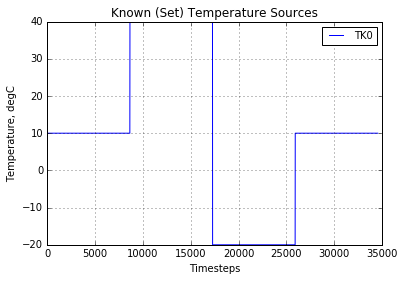

In [6]:
# Plot known temperature sources
fig = plt.figure()
plt.plot(TK)
labels = ['TK' + str(n) for n in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.xlabel('Timesteps')
plt.ylabel('Temperature, degC')
plt.title('Known (Set) Temperature Sources')
plt.grid()
plt.show()

### Initial Conditions

In [7]:
T[0,] = 10.      # all temperatures set to 10 degC

------------
## Run Simulation (Implicit Scheme)
Ideally, we should be able to reuse this part of the code applying only minimal changes. For cases where materials properties change over time or due to temperature, or when controls are present, the U-matrix completion should be done within the Main Loop.

### U-matrix completion

In [8]:
# Here, we complete the connections due to symmetry 
# Node 0 is connected to node 1; also, node 1 is connected to node 0.
U = -Uin - Uin.T  # U is symmetrical, non-diagonals are -ve
s = -np.sum(U,1)
for i in range(0,nN):
    U[i,i] = s[i] + np.sum(F[i,]) + C[i]/dt
del s

### Main Loop

In [9]:
# Loop for all timesteps
for t in range(0,nt-1):

    # Heat flow into the node, external sources
    Qin = np.zeros((nN,1))
    # Qin[0] = q_in # add heat sources here

    # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
    Q = Qin + np.reshape(np.dot(F, TK[t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[t,],(nN,1)))

    # Compute temperature
    # This is where the magic happens. For a system where nothing changes 
    # (no controls, no moveable blinds, no PCM; we need only define the 
    # U-matrix once (done above) and use it here)
    T[t+1,] = np.linalg.solve(U, Q).T

### Plotting

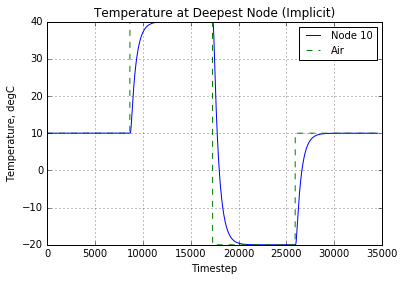

In [10]:
fig = plt.figure()
plt.plot(T[:,-1])
plt.hold(True)
plt.plot(TK, '--')
plt.legend(['Node 10', 'Air'],loc='best', fontsize='medium')
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.title('Temperature at Deepest Node (Implicit)')
plt.grid()
plt.show()

------------
## Run Simulation (Explicit Scheme)

In [15]:
# Calculate critical timestep; timestep <= critical timestep
critical_dt = rho_concrete*cp_concrete*(dx/2)**2/(2*k_concrete)
print "The critical timestep is: %0.f sec, while the selected timestep is: %.0f sec" %(critical_dt, dt)

The critical timestep is: 1361 sec, while the selected timestep is: 900 sec


In [12]:
# Declare variables
Te = np.zeros((nt,nN))  # degC, temperatures for explicit mode
Te[0,] = T[0,]          # initial condition set to be the same as implicit case

# RHS matrix
Ue = Uin + Uin.T
s = -np.sum(Ue,1)
for i in range(0,nN):
    Ue[i,i] = s[i] - np.sum(F[i,]) + C[i]/dt
del s
Und = Uin + Uin.T       # Without the diagonals

### Main Loop

In [13]:
# Loop for all timesteps in a day
for t in range(0,nt-1):

    # Heat flow into the node
    Qin = np.zeros((nN,1))
    # Qin[0] = q_in # add heat sources here

    # Q-vector (explicit): Q = Qin + F*TM(t)
    Q = Qin + np.reshape(np.dot(F, TK[t,]),(nN,1))

    # Compute temperature
    # This is where the magic happens. Prepare to be amazed!
    for c in range(nN):

        # Nodes with capacitance (diffusion nodes)
        if (C[c] != 0.):
            Te[t+1,c] = dt/C[c] * (np.dot(Ue[c,],Te[t,]) + Q[c])

        # Nodes without capacitance (arithmetic nodes)
        else:
            Te[t+1,c] = (np.dot(Und[c,],Te[t,]) + np.dot(F[c,],TK[t,]) + Qin[c]) \
                        / (np.sum(Und[c,]) + np.sum(F[c,]))

### Plotting

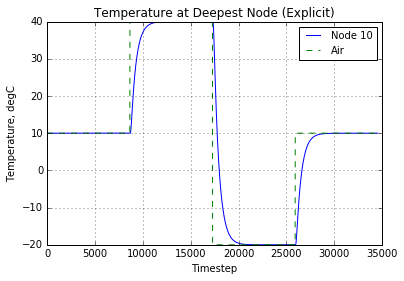

In [14]:
fig = plt.figure()
plt.plot(Te[:,-1])
plt.hold(True)
plt.plot(TK, '--')
plt.legend(['Node 10', 'Air'],loc='best', fontsize='medium')
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.title('Temperature at Deepest Node (Explicit)')
plt.grid()
plt.show()